<a href="https://www.kaggle.com/code/suyashsachdeva/resent50-classifier?scriptVersionId=244374073" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, GaussianNoise, Input, Rescaling
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import ModelCheckpoint

2025-06-08 13:22:28.048481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749388948.240841      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749388948.300993      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = np.load(r"/kaggle/input/pneumoniamnist/pneumoniamnist.npz")
dataset["train_images"].shape, dataset["train_labels"].shape

((3882, 28, 28), (3882, 1))

In [3]:
def normalization(image_set):
    min_val = np.min(image_set)
    max_val = np.max(image_set)
    difference = max_val - min_val
    return (image_set - min_val) / difference

In [4]:
xtrain = normalization(dataset["train_images"].reshape(-1, 28, 28, 1))
ytrain = dataset["train_labels"]

xvalid = normalization(dataset["val_images"].reshape(-1, 28, 28, 1))
yvalid = dataset["val_labels"]

xtest  = normalization(dataset["test_images"].reshape(-1, 28, 28, 1))
ytest = dataset["test_labels"]

Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


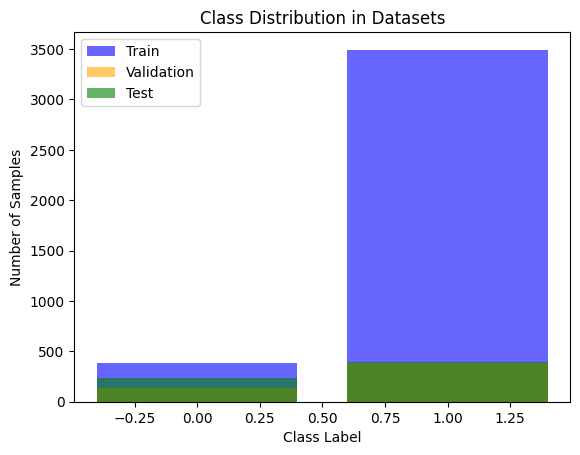

In [5]:
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")

# Optional: visualize imbalance
plt.bar(unique_train, counts_train, color='blue', alpha=0.6, label='Train')
plt.bar(unique_val, counts_val, color='orange', alpha=0.6, label='Validation')
plt.bar(unique_test, counts_test, color='green', alpha=0.6, label='Test')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.legend()
plt.title("Class Distribution in Datasets")
plt.show()


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Identify class counts
unique_train, counts_train = np.unique(ytrain, return_counts=True)
majority_class_count = np.max(counts_train)

# Initialize augmentation generator
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=True,
)

augmented_images = []
augmented_labels = []

# Augment both classes to balance data, not just the minority
for cls in unique_train:
    cls_indices = np.where(ytrain.flatten() == cls)[0]
    cls_images = xtrain[cls_indices]
    cls_labels = ytrain[cls_indices]

    current_count = len(cls_indices)
    samples_needed = majority_class_count - current_count

    if samples_needed > 0:
        aug_per_sample = samples_needed // current_count + 1
        for img, lbl in zip(cls_images, cls_labels):
            aug_iter = datagen.flow(img.reshape(1, *img.shape), lbl.reshape(1, *lbl.shape), batch_size=1)
            for _ in range(aug_per_sample):
                aug_img, aug_lbl = next(aug_iter)
                augmented_images.append(aug_img[0])
                augmented_labels.append(aug_lbl[0])
                if len(augmented_labels) >= samples_needed:
                    break
            if len(augmented_labels) >= samples_needed:
                break

# Convert to arrays and reshape labels if necessary
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if ytrain.ndim == 2:
    augmented_labels = augmented_labels.reshape(-1, 1)

# Combine original and augmented data
xtrain_balanced = np.concatenate([xtrain, augmented_images], axis=0)
ytrain_balanced = np.concatenate([ytrain, augmented_labels], axis=0)

# Final distribution check
unique_bal, count_bal = np.unique(ytrain_balanced, return_counts=True)
print("After Augmentation:")
for cls, count in zip(unique_bal, count_bal):
    print(f"Class {cls}: {count} samples")


After Augmentation:
Class 0: 3494 samples
Class 1: 3494 samples


In [7]:
def shuffle_dataset(x, y):
    assert len(x) == len(y), "Features and labels must have the same length"
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    return x[indices], y[indices]

for _ in range(10):
    xtrain_balanced, ytrain_balanced = shuffle_dataset(xtrain_balanced, ytrain_balanced)

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1, L2

input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

# Convert grayscale to 3-channel by concatenation
x = Concatenate()([input_layer, input_layer, input_layer])

# Load base model with imagenet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 2 residual blocks: 'conv4_block1' and 'conv5_block1' onward
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith('conv3'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True

# Regularization
weight_reg = L2(1e-4)
bias_reg = L1(1e-6)

# Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=weight_reg, bias_regularizer=bias_reg)(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid', kernel_regularizer=weight_reg, bias_regularizer=bias_reg)(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()


I0000 00:00:1749388964.895046      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 3)      │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 34, 34, 3)      │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 14, 14, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 14, 14, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 14, 14, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 16, 16, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 7, 7, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 7, 7, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 7, 7, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 7, 7, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 23,832,577 (90.91 MB)

 Non-trainable params: 279,936 (1.07 MB)

In [9]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-7)
        specificity = self.tn / (self.tn + self.fp + 1e-7)
        return (recall + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)



class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [10]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Callback to restore best weights after training
restore_best_weights = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)


In [11]:

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,      # number of steps after which decay is applied
    decay_rate=0.96,        # decay rate
    staircase=True          # if True, learning rate decays in discrete steps
)


model.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="bce",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')  # instance of the class
    ]
)

history = model.fit(
    xtrain_balanced, ytrain_balanced,
    validation_data=(xvalid, yvalid),
    epochs=1000,
    verbose=1,
    callbacks=[restore_best_weights, checkpoint]
)


Epoch 1/1000


I0000 00:00:1749389009.524990      59 service.cc:148] XLA service 0x79d4180021f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749389009.525675      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749389013.586358      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5568 - auc: 0.4244 - f1_score: 0.5046 - loss: 1.2344

I0000 00:00:1749389027.844816      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8604 - auc: 0.8887 - f1_score: 0.8629 - loss: 0.4958
Epoch 1: val_accuracy improved from -inf to 0.74237, saving model to /kaggle/working/best_model.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 138ms/step - accuracy: 0.8607 - auc: 0.8890 - f1_score: 0.8632 - loss: 0.4950 - val_accuracy: 0.7424 - val_auc: 0.7933 - val_f1_score: 0.8521 - val_loss: 0.7688
Epoch 2/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9462 - auc: 0.9833 - f1_score: 0.9474 - loss: 0.2272
Epoch 2: val_accuracy improved from 0.74237 to 0.83397, saving model to /kaggle/working/best_model.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9462 - auc: 0.9834 - f1_score: 0.9474 - loss: 0.2270 - val_accuracy: 0.8340 - val_auc: 0.9705 - val_f1_score: 0.8748 - val_loss: 0.3773
Epoch 3/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9601 - auc: 0.9926 - f1_score: 0.9610 - loss: 0.1466
Epoch 3: val_accuracy did not improve from 0

Test Loss: 0.5445
Test Balanced Accuracy: 0.8686
Test AUC: 0.9454
Test F1-Score: 0.9042


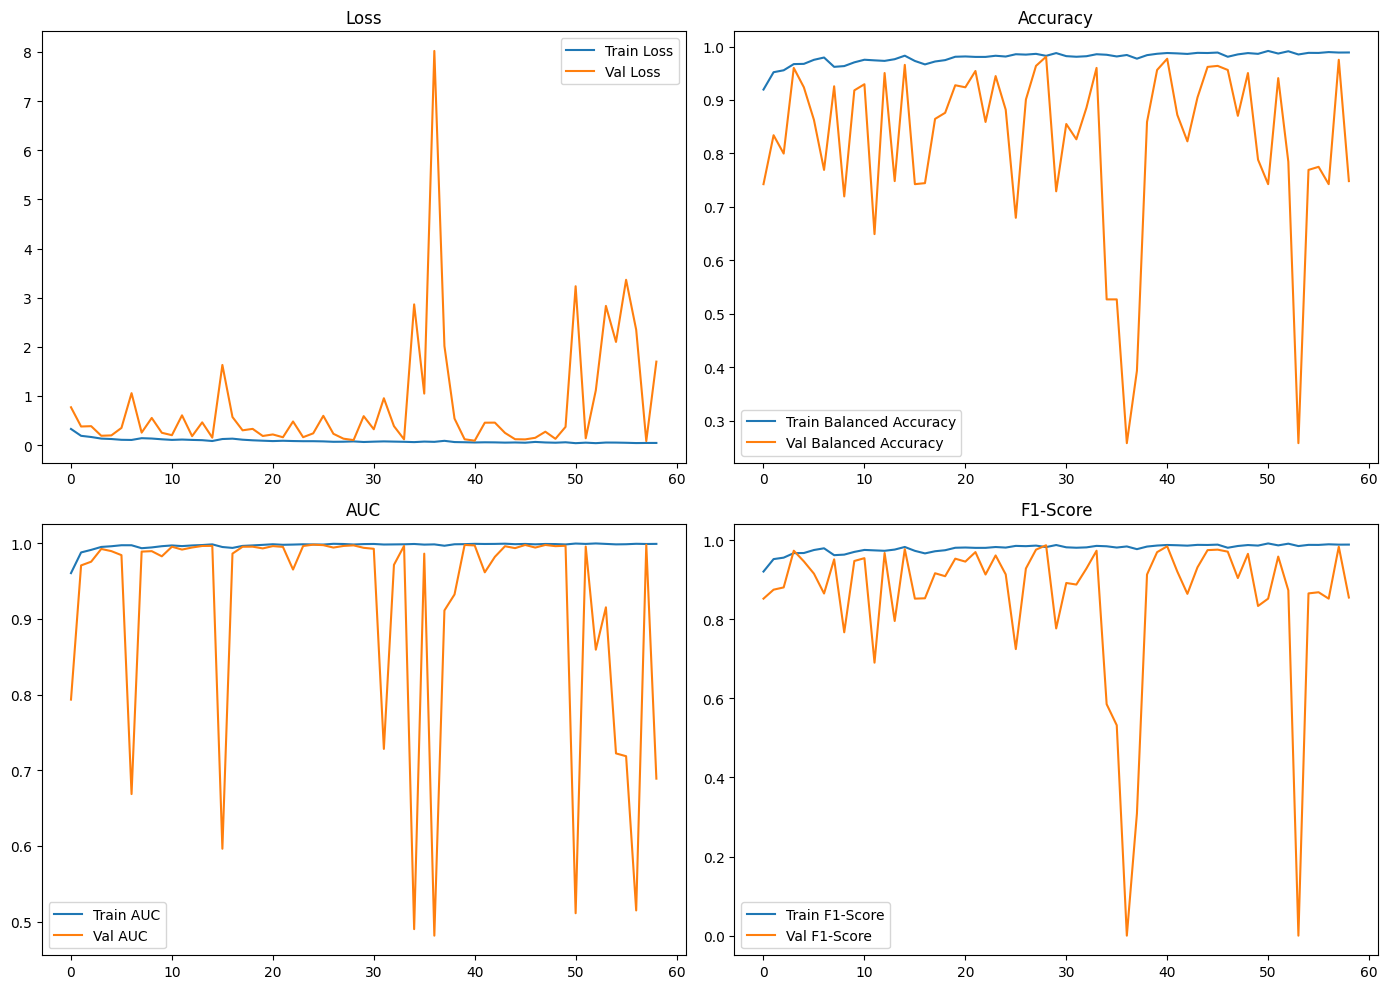

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Balanced Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Balanced Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC')

    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1-Score')
    plt.plot(history.history['val_f1_score'], label='Val F1-Score')
    plt.legend()
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

test_metrics = model.evaluate(xtest, ytest, verbose=0)

print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test F1-Score: {test_metrics[3]:.4f}")


plot_metrics(history)